# Dependencies

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os

# Add src to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

from src.models import Slots
from src.agents.agent_class import RandomAgent
from src.agents.cap_based_agent import CapAgent
from src.agents.dynamic_cap_based_agent import DynamicCapAgent
from src.agents.rl_deep_agent import RLDeepAgent
from src.agents.smart_auction_agent import SmartAuctionAgent
from src.auction import Auction
from src.data_loader import load_players_from_excel

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## Define Auction Configurations

In [2]:
# Create the smart auction agent
smart_agent = SmartAuctionAgent("smart_agent", mode="evaluation", initial_credits=100)

# If you have a trained model, load it
try:
    smart_agent.load_model("src/agents/smart_auction_weights/smart_auction_best.pth")
    print("✅ Loaded trained Smart Auction Agent")
except:
    print("⚠️ Using untrained Smart Auction Agent")

def refresh_agents():
    agents = [
        smart_agent,
        RandomAgent(agent_id="random_1"),
        RandomAgent(agent_id="random_2"),
        RandomAgent(agent_id="random_3"),
        CapAgent(agent_id="cap_tier_1", cap_strategy="tier_based"),
        CapAgent(agent_id="cap_tier_2", cap_strategy="tier_based"),
    ]
    return agents

# Auction configurations to test
auction_types = [
    {"auction_type": "random", "per_ruolo": True},
    # {"auction_type": "random", "per_ruolo": False},
    # {"auction_type": "listone", "per_ruolo": True},
    # {"auction_type": "listone", "per_ruolo": False},
    # {"auction_type": "chiamata", "per_ruolo": True},
    # {"auction_type": "chiamata", "per_ruolo": False}
]

initial_credits = 1000
slots = Slots()
print(f"Slots: {slots}")

Smart auction model loaded from src/agents/smart_auction_weights/smart_auction_best.pth
✅ Loaded trained Smart Auction Agent
Slots: <src.models.Slots object at 0x0000024871F2DDD0>


c:\archvio_nicola\fantabot\src\agents\smart_auction_agent.py:370: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


## Simulation Functions

In [3]:
def run_single_simulation(auction_types, slots, initial_credits, sim_id):
    """Run a single auction simulation with the 8 fixed agents"""
    
    # reload the listone and agents every simulation
    listone = load_players_from_excel()
    agents = refresh_agents()  
    random.shuffle(agents)  # Shuffle order for each simulation
    
    # Create and run auction
    auction = Auction(slots, agents, listone, initial_credits)
    auction.run_all(
        auction_type=auction_types["auction_type"],
        per_ruolo=auction_types["per_ruolo"],
        verbose=False
    )
    
    # Collect results - focus on key metrics
    results = []
    for agent in auction.agents:
        # Calculate credits spent and player count
        credits_spent = initial_credits - agent.current_credits
        players_count = len(agent.squad.gk) + len(agent.squad.def_) + len(agent.squad.mid) + len(agent.squad.att)
        
        squad_metrics = {
            "simulation_id": sim_id,
            "auction_type": auction_types["auction_type"],
            "per_ruolo": auction_types["per_ruolo"],
            "agent_id": agent.agent_id,
            "agent_type": type(agent).__name__,
            "total_evaluation": agent.squad.objective(standardized=True),
            "bestxi_evaluation": agent.squad.objective(bestxi=True, standardized=True),
            "credits_spent": credits_spent,
            "players_count": players_count,
        }
        
        # Add agent-specific parameters
        if hasattr(agent, 'bestxi_budget'):
            squad_metrics["bestxi_budget"] = agent.bestxi_budget
        
        results.append(squad_metrics)
    
    return results

print("✅ Simulation functions defined")

✅ Simulation functions defined


## Run Multiple Simulations

In [4]:
# Configuration for the simulation run
num_simulations_per_config = 10  # 1 simulation per auction configuration
total_simulations = len(auction_types) * num_simulations_per_config

print(f"🚀 Running {len(auction_types)} auction configs × {num_simulations_per_config} simulations = {total_simulations} total simulations...")

# Run all simulations
all_results = []
current_sim = 0

for auction_config in auction_types:
    for sim_num in range(num_simulations_per_config):
        current_sim += 1
        sim_id = f"{auction_config['auction_type']}_{auction_config['per_ruolo']}_{sim_num+1}"
        
        print(f"📊 Running simulation {current_sim}/{total_simulations}: {sim_id}")
        
        # Set random seed for reproducible shuffling within each sim
        random.seed(current_sim * 42)
        
        results = run_single_simulation(
            auction_config, 
            slots, 
            initial_credits, 
            sim_id
        )
        
        all_results.extend(results)

print(f"\n✅ Completed {total_simulations} simulations!")
print(f"📈 Collected {len(all_results)} agent results")

🚀 Running 1 auction configs × 10 simulations = 10 total simulations...
📊 Running simulation 1/10: random_True_1
📊 Running simulation 2/10: random_True_2
📊 Running simulation 3/10: random_True_3
📊 Running simulation 4/10: random_True_4
📊 Running simulation 5/10: random_True_5
📊 Running simulation 6/10: random_True_6
📊 Running simulation 7/10: random_True_7
📊 Running simulation 8/10: random_True_8
📊 Running simulation 9/10: random_True_9
📊 Running simulation 10/10: random_True_10

✅ Completed 10 simulations!
📈 Collected 60 agent results


## Analyze Results

In [5]:
# Convert results to DataFrame for analysis
df_results = pd.DataFrame(all_results)

print("📊 Results Summary:")
print(f"Total simulations: {df_results['simulation_id'].nunique()}")
print(f"Total agent results: {len(df_results)}")
print(f"Results per agent: {len(df_results) // 8}")

print(f"\n📋 Agent distribution:")
print(df_results['agent_id'].value_counts().sort_index())

📊 Results Summary:
Total simulations: 10
Total agent results: 60
Results per agent: 7

📋 Agent distribution:
agent_id
cap_tier_1     10
cap_tier_2     10
random_1       10
random_2       10
random_3       10
smart_agent    10
Name: count, dtype: int64


## Performance Analysis by Agent Type

In [6]:
# Agent Performance Summary Table
print("🏆 AGENT PERFORMANCE SUMMARY")
print("="*80)

agent_summary = df_results.groupby('agent_id').agg({
    'total_evaluation': ['mean', 'std', 'min', 'max'],
    'bestxi_evaluation': ['mean', 'std', 'min', 'max']
}).round(1)

# Flatten column names
agent_summary.columns = ['_'.join(col).strip() for col in agent_summary.columns.values]
agent_summary = agent_summary.reset_index()

# Sort by bestxi_evaluation mean (descending)
agent_summary = agent_summary.sort_values('bestxi_evaluation_mean', ascending=False)

print("\nRanked by Best XI Performance:")
for _, row in agent_summary.iterrows():
    print(f"{row['agent_id']:20} | Best XI: {row['bestxi_evaluation_mean']:5.1f} ± {row['bestxi_evaluation_std']:4.1f} | Total: {row['total_evaluation_mean']:5.1f} ± {row['total_evaluation_std']:4.1f}")

print(f"\nDetailed table:")
display(agent_summary)

🏆 AGENT PERFORMANCE SUMMARY

Ranked by Best XI Performance:
cap_tier_2           | Best XI:   3.2 ±  0.6 | Total:   4.7 ±  0.9
cap_tier_1           | Best XI:   3.1 ±  0.6 | Total:   4.6 ±  0.9
random_2             | Best XI:   1.8 ±  0.7 | Total:   2.3 ±  0.8
random_3             | Best XI:   1.7 ±  0.6 | Total:   2.1 ±  0.6
random_1             | Best XI:   1.4 ±  0.5 | Total:   1.8 ±  0.6
smart_agent          | Best XI:   0.0 ±  0.0 | Total:   0.0 ±  0.0

Detailed table:


,agent_id,total_evaluation_mean,total_evaluation_std,total_evaluation_min,total_evaluation_max,bestxi_evaluation_mean,bestxi_evaluation_std,bestxi_evaluation_min,bestxi_evaluation_max
1,cap_tier_2,4.7,0.9,3.4,6.1,3.2,0.6,2.5,4.1
0,cap_tier_1,4.6,0.9,3.0,6.0,3.1,0.6,2.1,4.0
3,random_2,2.3,0.8,1.2,3.7,1.8,0.7,0.8,3.0
4,random_3,2.1,0.6,1.0,3.0,1.7,0.6,0.7,2.4
2,random_1,1.8,0.6,0.7,2.7,1.4,0.5,0.5,2.2
5,smart_agent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Credits Spent and Player Count Analysis

Compare the distribution of credits spent and number of players acquired by each agent across all simulations.

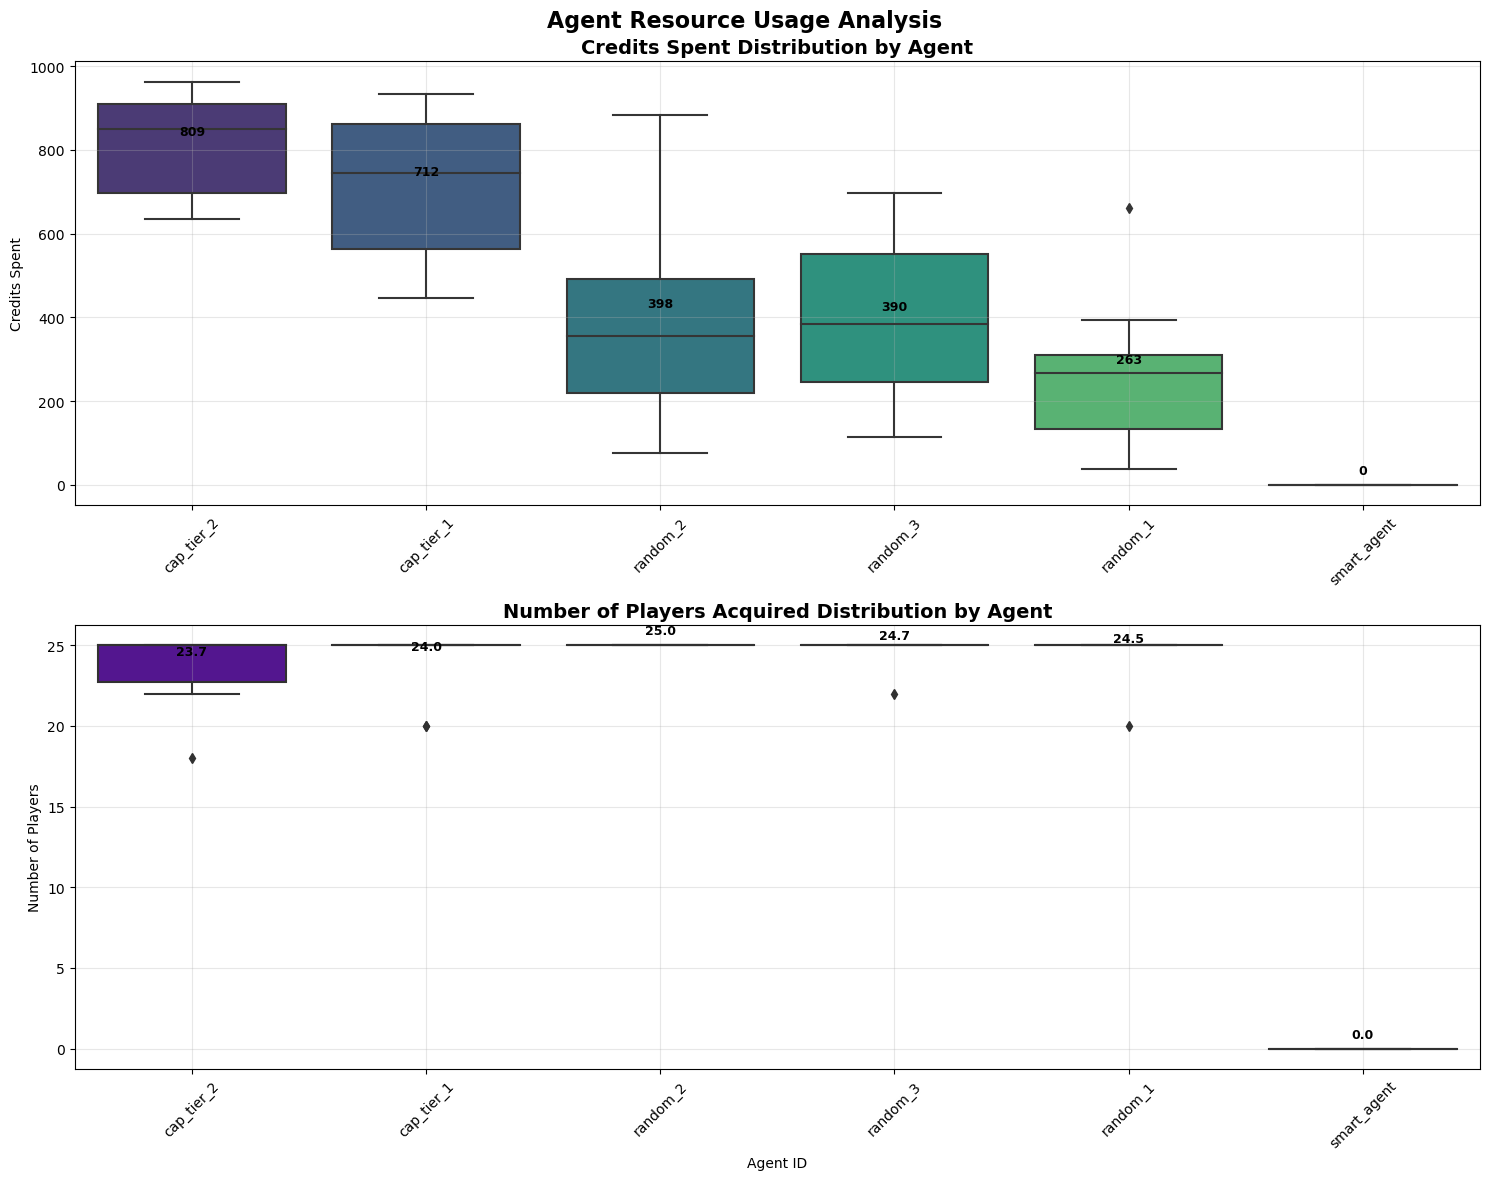

💰 CREDITS SPENT ANALYSIS
cap_tier_2           | Mean:  809.2 | Std: 121.2 | Range:  634- 963
cap_tier_1           | Mean:  712.2 | Std: 180.2 | Range:  445- 933
random_2             | Mean:  397.7 | Std: 258.1 | Range:   76- 882
random_3             | Mean:  389.5 | Std: 204.1 | Range:  114- 697
random_1             | Mean:  262.9 | Std: 180.4 | Range:   37- 660
smart_agent          | Mean:    0.0 | Std:   0.0 | Range:    0-   0

👥 PLAYER COUNT ANALYSIS
cap_tier_2           | Mean:   23.7 | Std:   2.4 | Range:   18-  25
cap_tier_1           | Mean:   24.0 | Std:   2.1 | Range:   20-  25
random_2             | Mean:   25.0 | Std:   0.0 | Range:   25-  25
random_3             | Mean:   24.7 | Std:   0.9 | Range:   22-  25
random_1             | Mean:   24.5 | Std:   1.6 | Range:   20-  25
smart_agent          | Mean:    0.0 | Std:   0.0 | Range:    0-   0

💡 Resource usage patterns show how different strategies allocate credits and acquire players


In [7]:
# Create visualizations for credits spent and player counts
agents_list = df_results['agent_id'].unique()
agents_list = sorted(agents_list)  # Sort for consistent ordering

# Create a 2x1 subplot for credits and player counts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
fig.suptitle('Agent Resource Usage Analysis', fontsize=16, fontweight='bold')

# Sort agents by performance for better visualization
agent_order = df_results.groupby('agent_id')['bestxi_evaluation'].mean().sort_values(ascending=False).index

# Credits Spent Distribution
sns.boxplot(data=df_results, x='agent_id', y='credits_spent', 
           order=agent_order, ax=ax1, palette="viridis")
ax1.set_title('Credits Spent Distribution by Agent', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Credits Spent')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add mean values as text
for i, agent in enumerate(agent_order):
    mean_credits = df_results[df_results['agent_id'] == agent]['credits_spent'].mean()
    ax1.text(i, mean_credits + 20, f'{mean_credits:.0f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# Player Count Distribution
sns.boxplot(data=df_results, x='agent_id', y='players_count', 
           order=agent_order, ax=ax2, palette="plasma")
ax2.set_title('Number of Players Acquired Distribution by Agent', fontsize=14, fontweight='bold')
ax2.set_xlabel('Agent ID')
ax2.set_ylabel('Number of Players')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add mean values as text
for i, agent in enumerate(agent_order):
    mean_players = df_results[df_results['agent_id'] == agent]['players_count'].mean()
    ax2.text(i, mean_players + 0.5, f'{mean_players:.1f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("💰 CREDITS SPENT ANALYSIS")
print("="*60)
credits_summary = df_results.groupby('agent_id')['credits_spent'].agg(['mean', 'std', 'min', 'max']).round(1)
credits_summary = credits_summary.loc[agent_order]
for agent in agent_order:
    stats = credits_summary.loc[agent]
    print(f"{agent:20} | Mean: {stats['mean']:6.1f} | Std: {stats['std']:5.1f} | Range: {stats['min']:4.0f}-{stats['max']:4.0f}")

print(f"\n👥 PLAYER COUNT ANALYSIS")
print("="*60)
players_summary = df_results.groupby('agent_id')['players_count'].agg(['mean', 'std', 'min', 'max']).round(1)
players_summary = players_summary.loc[agent_order]
for agent in agent_order:
    stats = players_summary.loc[agent]
    print(f"{agent:20} | Mean: {stats['mean']:6.1f} | Std: {stats['std']:5.1f} | Range: {stats['min']:4.0f}-{stats['max']:4.0f}")

print(f"\n💡 Resource usage patterns show how different strategies allocate credits and acquire players")

## Comparative Box Plots

Side-by-side comparison of all agents showing quartiles and outliers.

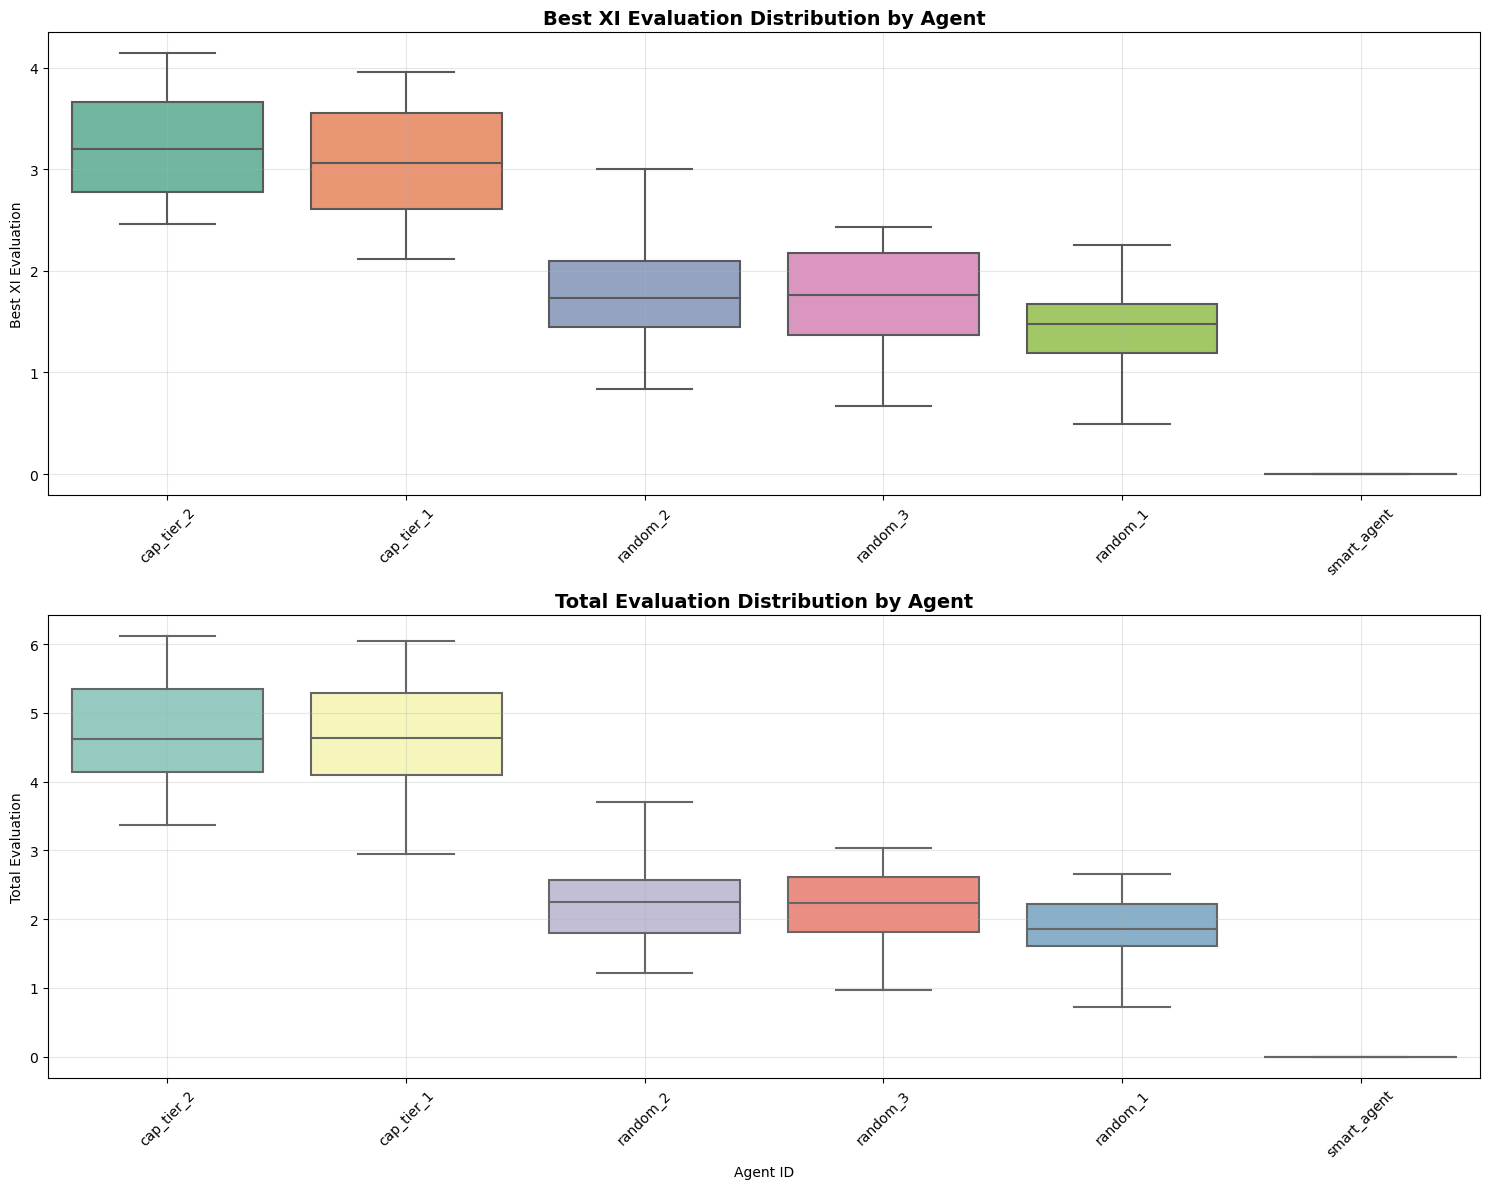

🏆 AGENT RANKINGS

By Best XI Evaluation (mean):
 1. cap_tier_2           3.2
 2. cap_tier_1           3.1
 3. random_2             1.8
 4. random_3             1.7
 5. random_1             1.4
 6. smart_agent          0.0

By Total Evaluation (mean):
 1. cap_tier_2           4.7
 2. cap_tier_1           4.6
 3. random_2             2.3
 4. random_3             2.1
 5. random_1             1.8
 6. smart_agent          0.0


In [8]:
# Create comparative box plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Sort agents by performance for better visualization
agent_order = df_results.groupby('agent_id')['bestxi_evaluation'].mean().sort_values(ascending=False).index

# Best XI Evaluation box plot
sns.boxplot(data=df_results, x='agent_id', y='bestxi_evaluation', 
           order=agent_order, ax=ax1, palette="Set2")
ax1.set_title('Best XI Evaluation Distribution by Agent', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Best XI Evaluation')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Total Evaluation box plot
sns.boxplot(data=df_results, x='agent_id', y='total_evaluation', 
           order=agent_order, ax=ax2, palette="Set3")
ax2.set_title('Total Evaluation Distribution by Agent', fontsize=14, fontweight='bold')
ax2.set_xlabel('Agent ID')
ax2.set_ylabel('Total Evaluation')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print ranking
print("🏆 AGENT RANKINGS")
print("="*50)
print("\nBy Best XI Evaluation (mean):")
for i, agent in enumerate(agent_order, 1):
    mean_score = df_results[df_results['agent_id'] == agent]['bestxi_evaluation'].mean()
    print(f"{i:2}. {agent:20} {mean_score:.1f}")

print(f"\nBy Total Evaluation (mean):")
total_order = df_results.groupby('agent_id')['total_evaluation'].mean().sort_values(ascending=False).index
for i, agent in enumerate(total_order, 1):
    mean_score = df_results[df_results['agent_id'] == agent]['total_evaluation'].mean()
    print(f"{i:2}. {agent:20} {mean_score:.1f}")

## Export Results and Summary

In [9]:
# Save results to CSV for further analysis
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_filename = f"logs/agent_performance_{timestamp}.csv"

df_results.to_csv(results_filename, index=False)
print(f"📁 Results saved to: {results_filename}")

# Final summary
print(f"\n📊 FINAL SUMMARY")
print("="*60)
print(f"Total simulations run: {total_simulations}")
print(f"Results per agent: {total_simulations}")
print(f"Auction configurations tested: {len(auction_configs)}")

# Winner analysis
print(f"\n🏆 OVERALL WINNERS")
print("="*40)
best_bestxi = df_results.loc[df_results['bestxi_evaluation'].idxmax()]
best_total = df_results.loc[df_results['total_evaluation'].idxmax()]

print(f"Best XI champion: {best_bestxi['agent_id']} with {best_bestxi['bestxi_evaluation']:.1f}")
print(f"Total eval champion: {best_total['agent_id']} with {best_total['total_evaluation']:.1f}")

print(f"\nMost consistent performer (lowest std dev in Best XI):")
consistency = df_results.groupby('agent_id')['bestxi_evaluation'].std().sort_values()
most_consistent = consistency.index[0]
print(f"{most_consistent} (std dev: {consistency.iloc[0]:.1f})")

📁 Results saved to: logs/agent_performance_20251016_173645.csv

📊 FINAL SUMMARY
Total simulations run: 10
Results per agent: 10


NameError: name 'auction_configs' is not defined

## Key Insights

Based on the simulation results above:

### 🎯 **Agent Performance Insights:**
- **Kernel histograms** show the distribution shape for each agent's performance
- **Box plots** reveal quartiles, medians, and outliers for direct comparison
- **Rankings** identify the most effective strategies

### 📈 **What to Look For:**
1. **Consistent performers** - Agents with narrow distributions (low variance)
2. **High performers** - Agents with high mean scores
3. **Reliable strategies** - Agents that avoid very low scores
4. **CapAgent optimization** - Which bestxi_budget values work best

### 🔄 **Next Steps:**
- Increase `num_simulations_per_config` for more robust statistics
- Test different bestxi_budget values based on insights
- Focus on the top-performing agent strategies for real auctions